# 04 — Structural-Aware ΔΔG Model for 1EY0A

This notebook trains a **Random Forest ΔΔG regression model** for the protein  
**1EY0A (Staphylococcal Nuclease)** using:

- Sequence Δ features (hydropathy, charge, volume, polarity)
- Substitution score (BLOSUM62)
- Environment (pH, temperature)
- Structural features from DSSP:
  - `ss_idx`, `ss_H`, `ss_E`, `ss_C`
  - `asa`, `asa_norm`
  - `is_buried`, `is_exposed`

Input file (already created by `feature_engineering.py`):

- `data/processed/features_structural.csv`

We:
1. Filter to `clid == "1EY0A"`.
2. Define a feature set that includes structural columns.
3. Run 5-fold cross-validation.
4. Fit the final model and inspect train performance.
5. (Optional) Plot predicted vs experimental ΔΔG for 1EY0A.

In [5]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Reuse the same random seed
RANDOM_STATE = 42

# Resolve project root (works whether you run from notebooks/ or project root)
PROJECT_ROOT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"
RESULTS_DIR = PROJECT_ROOT / "results" / "models_structural"

print("Project root:", PROJECT_ROOT)
print("Processed data:", DATA_PROCESSED)
print("Results dir:", RESULTS_DIR)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

Project root: /Users/saturnine/protein-multimutant
Processed data: /Users/saturnine/protein-multimutant/data/processed
Results dir: /Users/saturnine/protein-multimutant/results/models_structural


In [6]:
# Load the enriched feature table (created by feature_engineering.py)
feat_path = DATA_PROCESSED / "features_structural.csv"
df_all = pd.read_csv(feat_path)

print("Full structural feature table shape:", df_all.shape)
df_all.head()

Full structural feature table shape: (2645, 27)


,clid,pdb_id,chain,wt,res_index,mut,ddg_exp_kcal,pH,temp_C,pos,...,is_to_gly,is_to_pro,ss_idx,ss_H,ss_E,ss_C,asa,asa_norm,is_buried,is_exposed
0,1A43A,1A43,A,C,218.0,S,-3.70,7.3,25.0,218.0,...,0,0,2,0,0,1,NaN,NaN,0,0
1,1A43A,1A43,A,E,159.0,D,-4.55,7.3,25.0,159.0,...,0,0,2,0,0,1,NaN,NaN,0,0
2,1A43A,1A43,A,G,156.0,A,-2.40,7.3,25.0,156.0,...,0,0,2,0,0,1,NaN,NaN,0,0
3,1A43A,1A43,A,R,167.0,A,-4.55,7.3,25.0,167.0,...,0,0,2,0,0,1,NaN,NaN,0,0
4,1A43A,1A43,A,W,184.0,A,-0.70,7.3,25.0,184.0,...,0,0,2,0,0,1,NaN,NaN,0,0


In [7]:
# Focus on a single, structurally-annotated protein
mask_1ey0a = (df_all["clid"] == "1EY0A")
df = df_all[mask_1ey0a].copy()

print("Shape for 1EY0A:", df.shape)
df.head()

Shape for 1EY0A: (482, 27)


,clid,pdb_id,chain,wt,res_index,mut,ddg_exp_kcal,pH,temp_C,pos,...,is_to_gly,is_to_pro,ss_idx,ss_H,ss_E,ss_C,asa,asa_norm,is_buried,is_exposed
500,1EY0A,1EY0,A,A,12.0,G,-2.37,7.0,20.0,12.0,...,1,0,0,0,1,0,12.0,0.041096,1,0
501,1EY0A,1EY0,A,A,12.0,V,-0.89,7.0,20.0,12.0,...,0,0,0,0,1,0,12.0,0.041096,1,0
502,1EY0A,1EY0,A,A,17.0,G,0.19,7.0,20.0,17.0,...,1,0,0,0,1,0,14.0,0.047945,1,0
503,1EY0A,1EY0,A,A,17.0,V,-1.94,7.0,20.0,17.0,...,0,0,0,0,1,0,14.0,0.047945,1,0
504,1EY0A,1EY0,A,A,58.0,G,-2.53,7.0,20.0,58.0,...,1,0,1,1,0,0,0.0,0.000000,1,0


In [8]:
# Quick check of structural-related columns
struct_cols = ["ss_idx", "ss_H", "ss_E", "ss_C", "asa", "asa_norm", "is_buried", "is_exposed"]

for col in struct_cols:
    if col in df.columns:
        missing_frac = df[col].isna().mean()
        print(f"{col:10s}  missing fraction: {missing_frac:.3f}")
    else:
        print(f"[WARN] Column {col} not found in dataframe")

ss_idx      missing fraction: 0.000
ss_H        missing fraction: 0.000
ss_E        missing fraction: 0.000
ss_C        missing fraction: 0.000
asa         missing fraction: 0.000
asa_norm    missing fraction: 0.000
is_buried   missing fraction: 0.000
is_exposed  missing fraction: 0.000


In [9]:
target_col = "ddg_exp_kcal"

numeric_features = [
    # positional + environment
    "pos", "pH", "temp_C",
    # sequence / physicochemical Δ features
    "delta_hydropathy", "delta_charge", "delta_volume", "delta_polarity",
    "blosum62", "is_gly", "is_pro", "is_to_gly", "is_to_pro",
    # structural features from DSSP
    "ss_idx", "ss_H", "ss_E", "ss_C",
    "asa", "asa_norm", "is_buried", "is_exposed",
]

# Drop rows where any of these are missing
keep_cols = numeric_features + [target_col]
df_model = df.dropna(subset=keep_cols).copy()

print("Model dataframe shape after dropping NaNs:", df_model.shape)

X = df_model[numeric_features].values
y = df_model[target_col].values

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

Model dataframe shape after dropping NaNs: (482, 27)
Feature matrix shape: (482, 20)
Target vector shape: (482,)


In [10]:
# Standardize all numeric features
pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), list(range(len(numeric_features)))),
    ],
    remainder="drop",
)

# Use the RF configuration similar to your previous best model
rf = RandomForestRegressor(
    n_estimators=600,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=RANDOM_STATE,
)

pipe = Pipeline([
    ("pre", pre),
    ("reg", rf),
])

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

In [11]:
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

r2_scores = cross_val_score(pipe, X, y, cv=kf, scoring="r2")
rmse_scores = -cross_val_score(pipe, X, y, cv=kf, scoring="neg_root_mean_squared_error")

print(f"CV R2:   mean={r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print(f"CV RMSE: mean={rmse_scores.mean():.3f} ± {rmse_scores.std():.3f}")

CV R2:   mean=0.582 ± 0.065
CV RMSE: mean=0.872 ± 0.106


In [12]:
# Fit on all 1EY0A data (for downstream GA use on this protein)
pipe.fit(X, y)

y_pred = pipe.predict(X)
train_r2 = r2_score(y, y_pred)
train_rmse = rmse(y, y_pred)
train_mae = mean_absolute_error(y, y_pred)

print(f"Train R2:   {train_r2:.3f}")
print(f"Train RMSE: {train_rmse:.3f}")
print(f"Train MAE:  {train_mae:.3f}")

Train R2:   0.898
Train RMSE: 0.436
Train MAE:  0.315


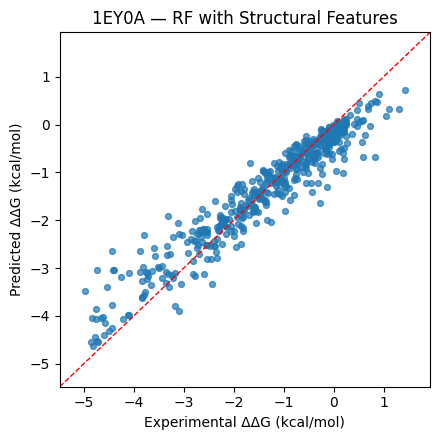

Saved scatter plot to: /Users/saturnine/protein-multimutant/results/models_structural/1EY0A_structural_rf_scatter.png


In [13]:
plt.figure(figsize=(4.5, 4.5))
plt.scatter(y, y_pred, s=18, alpha=0.7)
lims = [
    min(y.min(), y_pred.min()) - 0.5,
    max(y.max(), y_pred.max()) + 0.5
]
plt.plot(lims, lims, "r--", linewidth=1)
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("Experimental ΔΔG (kcal/mol)")
plt.ylabel("Predicted ΔΔG (kcal/mol)")
plt.title("1EY0A — RF with Structural Features")
plt.tight_layout()

plot_path = RESULTS_DIR / "1EY0A_structural_rf_scatter.png"
plt.savefig(plot_path, dpi=200)
plt.show()

print("Saved scatter plot to:", plot_path)

In [14]:
import joblib
import json

model_path = RESULTS_DIR / "rf_structural_1EY0A.pkl"
joblib.dump(pipe, model_path)

metrics = {
    "protein": "1EY0A",
    "n_samples": int(len(y)),
    "n_features": len(numeric_features),
    "features": numeric_features,
    "cv_r2_mean": float(r2_scores.mean()),
    "cv_r2_std": float(r2_scores.std()),
    "cv_rmse_mean": float(rmse_scores.mean()),
    "cv_rmse_std": float(rmse_scores.std()),
    "train_r2": float(train_r2),
    "train_rmse": float(train_rmse),
    "train_mae": float(train_mae),
}

metrics_path = RESULTS_DIR / "metrics_structural_1EY0A.json"
with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=2)

print("Saved model →", model_path)
print("Saved metrics →", metrics_path)

Saved model → /Users/saturnine/protein-multimutant/results/models_structural/rf_structural_1EY0A.pkl
Saved metrics → /Users/saturnine/protein-multimutant/results/models_structural/metrics_structural_1EY0A.json
